#Long Form Question Answering &amp; Generated Content Detection

In this notebook, we are going to implement a long-form question answering and generated content detection model using natrual language processing (NLP) tools.

The dataset used in this project is a subset of [ELI5 dataset](https://huggingface.co/datasets/eli5_category).

The first step is to load the data and learn about the characteristics of data.
Then we have to do some pre-proceesing on the text data in order to make it ready to be given to a model to learn.

# install datasets library

In [1]:
!pip install torch
!pip install accelerate==0.30.0

import accelerate
print(accelerate.__version__)

0.30.0


In [2]:
!pip install datasets

#Load dataset

In [3]:
from datasets import load_dataset
dataset = load_dataset("eli5_category")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for eli5_category contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/eli5_category
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.war

# EDA

##Let's see the structure of dataset

In [4]:
print('*'*100)
print('In the following part, you can see the structure of dataset:')
print('*'*100)
dataset

****************************************************************************************************
In the following part, you can see the structure of dataset:
****************************************************************************************************


DatasetDict({
    train: Dataset({
        features: ['q_id', 'title', 'selftext', 'category', 'subreddit', 'answers', 'title_urls', 'selftext_urls'],
        num_rows: 91772
    })
    validation1: Dataset({
        features: ['q_id', 'title', 'selftext', 'category', 'subreddit', 'answers', 'title_urls', 'selftext_urls'],
        num_rows: 5446
    })
    validation2: Dataset({
        features: ['q_id', 'title', 'selftext', 'category', 'subreddit', 'answers', 'title_urls', 'selftext_urls'],
        num_rows: 2375
    })
    test: Dataset({
        features: ['q_id', 'title', 'selftext', 'category', 'subreddit', 'answers', 'title_urls', 'selftext_urls'],
        num_rows: 5411
    })
})

##Let's see dataset information

In [5]:


import pandas as pd # I just created a dataframe of information
information_of_dataset = pd.DataFrame({'q_id': ['a string question identifier for each example, corresponding to its ID in the Pushshift.io Reddit submission dumps'],
                            'subreddit':['always explainlikeimfive, indicating which subreddit the question came from'],
                            'category':['tag of the question, the possible values are listed above.'],
                            'title':['title of the question, with URLs extracted and replaced by URL_n tokens'],
                            'title_urls':['list of the extracted URLs, the nth element of the list was replaced by URL_n'],
                            'selftext':['either an empty string or an elaboration of the question'],
                            'selftext_urls':['similar to title_urls but for self_text'],
                            'answers':['a list of answers, each answer has'],
                            'a_id':['a string answer identifier for each answer, corresponding to its ID in the Pushshift.io Reddit comments dumps.'],
                            'text':['he answer text with the URLs normalized'],
                            'score':['the number of upvotes - the number of downvotes the answer had received when the dumps were created'],
                            'text_urls': ['ists of the extracted URLs for every answer']},index=['description'])
print('In the following table, you can see dataset information. If you need to have a better view, try to use the icon on the right side')
print('*'*100)
information_of_dataset

In the following table, you can see dataset information. If you need to have a better view, try to use the icon on the right side
****************************************************************************************************


,q_id,subreddit,category,title,title_urls,selftext,selftext_urls,answers,a_id,text,score,text_urls
description,"a string question identifier for each example,...","always explainlikeimfive, indicating which sub...","tag of the question, the possible values are l...","title of the question, with URLs extracted and...","list of the extracted URLs, the nth element of...",either an empty string or an elaboration of th...,similar to title_urls but for self_text,"a list of answers, each answer has","a string answer identifier for each answer, co...",he answer text with the URLs normalized,the number of upvotes - the number of downvote...,ists of the extracted URLs for every answer


##Let's focues on train part of dataset and see the first element of raw_train_dataset

In [6]:

raw_train_dataset = dataset['train']
print('Let us see the first element of raw_train_dataset: ')
print('*'*100)
print('\n')

raw_train_dataset[0]

Let us see the first element of raw_train_dataset: 
****************************************************************************************************




{'q_id': '5lchat',
 'title': "Why there was a 'leap second' added to the end of 2016?",
 'selftext': '',
 'category': 'Other',
 'subreddit': 'explainlikeimfive',
 'answers': {'a_id': ['dbuoyxl', 'dbur7gi', 'dbuotht'],
  'text': ['the rotation of the earth is not a constant. in fact the rotation of the earth is slowing down, which means that a full day is getting slightly longer. without leap seconds our clocks would slowly drift ever so slightly out of sync with the actual day. we could deal with this by redefining how how long 1 second is, making it slightly longer so that one day is still exactly 24*60*60 seconds. but in practice that is really inconvenient for a lot of our technology which relies on very precise timing. its easier to just move us ahead one second every couple of years or so.',
   "The Earth's rotation is not regular. It varies a bit, so sometimes we add a second. We do this to ensure that noon is always going to be sometime around mid-day. If we did not add leap sec

#

## Let's create a better dictionary of dataset and remove some unnecessary columns

In [7]:


import numpy as np
def organize_dataset(dataset):
  '''
    input: dataset must be given as dataset['train'] or dataset['test']
  '''
  # Here, we just create a dictionary using the following columns
  #1)questions
  #2)self_text
  #3)categories
  #4)answers
  #5)answers_scores
  # Since other columns are unique acroos the whole dataset. If you would like to see wheater they are unique or not, you can
  # use the following commands
  print('Unique items in selftext_urls is just only: <', np.unique(dataset['selftext_urls'])[0],'> So, this column has been removed')
  print('Unique items in title_urls is just only: <', np.unique(dataset['title_urls'])[0],'> So, this column has been removed')
  print('Unique items in subreddit is just only: <', np.unique(dataset['subreddit'])[0],'> So, this column has been removed')


  questions = dataset['title']
  questions_selftext = dataset['selftext']
  categories = dataset['category']

  answers = []
  answers_scores = []
  for item in dataset:
    answers.append(item['answers']['text'])
    answers_scores.append(item['answers']['score'])

  dataset_dict = {"questions":questions, "selftext": questions_selftext, "category":categories, "answers":answers, "score":answers_scores}
  print('*'*100)
  print('Now, we have a clean datset dictionary with ',dataset_dict.keys())
  print('*'*100)
  return dataset_dict

In [8]:
dataset_dict = organize_dataset(dataset['train'])

Unique items in selftext_urls is just only: < url > So, this column has been removed
Unique items in title_urls is just only: < url > So, this column has been removed
Unique items in subreddit is just only: < explainlikeimfive > So, this column has been removed
****************************************************************************************************
Now, we have a clean datset dictionary with  dict_keys(['questions', 'selftext', 'category', 'answers', 'score'])
****************************************************************************************************


# Continue EDA

##Let's see the first 3 questions with their attributes

In [ ]:

for i in range(3):
  Question = dataset_dict['questions'][i]
  print(f'Question {i+1}: {Question}')
  Category = dataset_dict['category'][i]
  print(f"Category: {Category}")
  Answers = dataset_dict['answers'][i]

  index = 0
  for Answer in Answers:
    print(f"Answer {index+1}: {Answer} ")
    print(f"Score {index+1}: {dataset_dict['score'][i][index]}")
    index+=1

  print('*'*100)


Question 1: Why there was a 'leap second' added to the end of 2016?
Category: Other
Answer 1: the rotation of the earth is not a constant. in fact the rotation of the earth is slowing down, which means that a full day is getting slightly longer. without leap seconds our clocks would slowly drift ever so slightly out of sync with the actual day. we could deal with this by redefining how how long 1 second is, making it slightly longer so that one day is still exactly 24*60*60 seconds. but in practice that is really inconvenient for a lot of our technology which relies on very precise timing. its easier to just move us ahead one second every couple of years or so. 
Score 1: 44
Answer 2: The Earth's rotation is not regular. It varies a bit, so sometimes we add a second. We do this to ensure that noon is always going to be sometime around mid-day. If we did not add leap seconds, over a very long period of time where the Earth's rotation slowly changed, noon could end up being at dusk. We wa

##Let's trun dictionary to dataframe

In [ ]:
df = pd.DataFrame(dataset['train'])
df.head()

,q_id,title,selftext,category,subreddit,answers,title_urls,selftext_urls
0,5lchat,Why there was a 'leap second' added to the end...,,Other,explainlikeimfive,"{'a_id': ['dbuoyxl', 'dbur7gi', 'dbuotht'], 't...",[url],[url]
1,5lcjq6,How do you claim undiscovered land?,"If your on a boat, sailing through lets say th...",Other,explainlikeimfive,"{'a_id': ['dbuplm8', 'dbuocvb', 'dbux9vf'], 't...",[url],[url]
2,5lcl43,Why do we fail to do realistic human CGI (like...,"Title pretty much, thanks for answers in advance!",Technology,explainlikeimfive,"{'a_id': ['dbuns7l', 'dbunw2c', 'dbup34d', 'db...",[url],[url]
3,5lcr1h,Why is it that we calm down when we take a dee...,,Biology,explainlikeimfive,"{'a_id': ['dbuusst'], 'text': ['Anxiety/stress...",[url],[url]
4,5lcsyf,Why does 1080p on a 4k TV look better than 108...,,Technology,explainlikeimfive,"{'a_id': ['dbuq0qt', 'dbuqstj'], 'text': ['In ...",[url],[url]


##Let's find category frequency

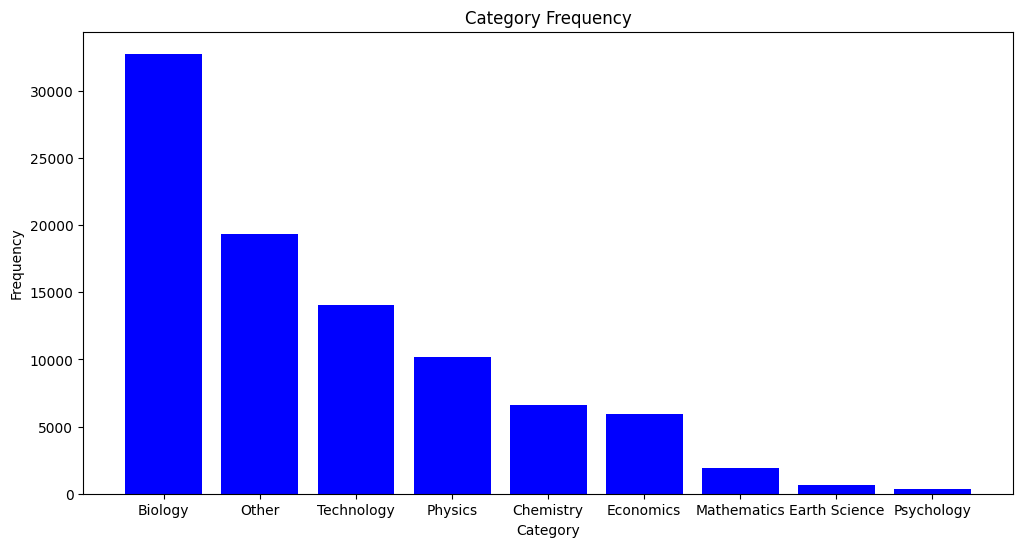

****************************************************************************************************
In the above picture, you can see that we are dealing with a kind of imbalanced dataset so that Bilogy category includes about 30,000 questions
****************************************************************************************************


In [ ]:
import matplotlib.pyplot as plt

category_counts = df['category'].value_counts()

# Plotting the bar chart
plt.figure(figsize=(12, 6))  # Adjust the size of your plot
plt.bar(category_counts.index, category_counts.values, color='blue')  # You can choose your own color
plt.xlabel('Category')  # Label for the x-axis
plt.ylabel('Frequency')  # Label for the y-axis
plt.title('Category Frequency')  # Title of the plot
plt.show()
print('*'*100)
print('In the above picture, you can see that we are dealing with a kind of imbalanced dataset so that Bilogy category includes about 30,000 questions')
print('*'*100)

##Let's find Word frequency

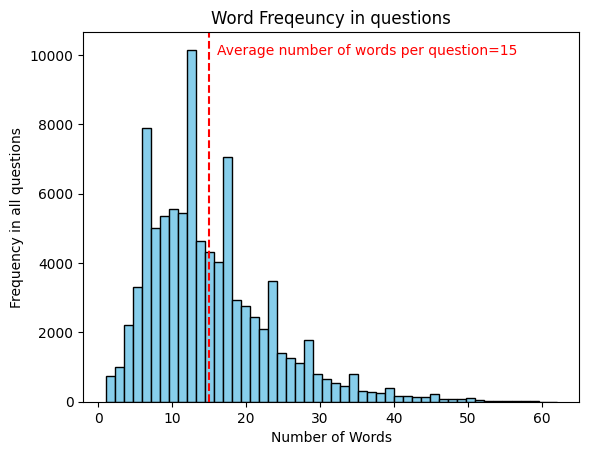

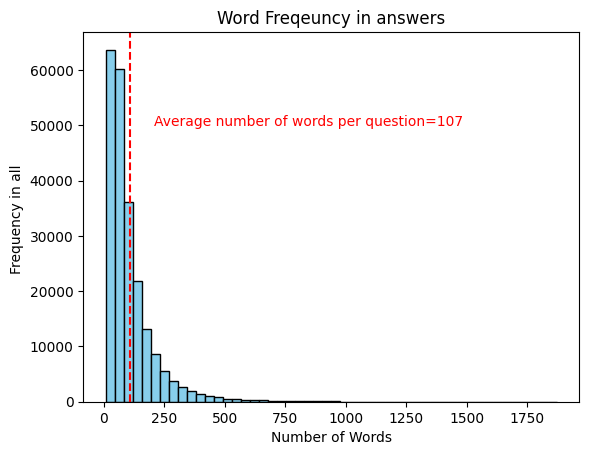

In [ ]:
questions_words_count = []
for q in dataset_dict['questions']:
  questions_words_count.append(len(q.split()))


mean_questions_words_count = int(np.mean(questions_words_count))
#print(f'\tAverage number of words per question: {mean_questions_words_count}')


# Create histogram with bins
plt.hist(questions_words_count, bins=50, color='skyblue', edgecolor='black')
plt.axvline(x=mean_questions_words_count, color='red', linestyle='--')

# Add labels and title
plt.xlabel('Number of Words')
plt.ylabel('Frequency in all questions')
plt.title('Word Freqeuncy in questions')
plt.text(mean_questions_words_count+1, 10000, f'Average number of words per question={mean_questions_words_count}', color='red')

# Show plot
plt.show()

answers_words_count = []
for ans_list in dataset_dict['answers']:
  for ans in ans_list:
    answers_words_count.append(len(ans.split()))

mean_answers_words_count = int(np.mean(answers_words_count))
#print(f'\tAverage number of words per answers: {mean_answers_words_count}')


# Create histogram with bins
plt.hist(answers_words_count, bins=50, color='skyblue', edgecolor='black')
plt.axvline(x=mean_answers_words_count, color='red', linestyle='--')
# Add labels and title
plt.xlabel('Number of Words')
plt.ylabel('Frequency in all ')
plt.title('Word Freqeuncy in answers')
plt.text(mean_answers_words_count+100, 50000, f'Average number of words per question={mean_answers_words_count}', color='red')

# Show plot
plt.show()

## Let's find average number of answers per question

list_of_numbers_of_answers:  [3, 3, 4, 1, 2, 1, 1, 13, 2, 4]
average_asnwers_per_question:  2.4418014209126966


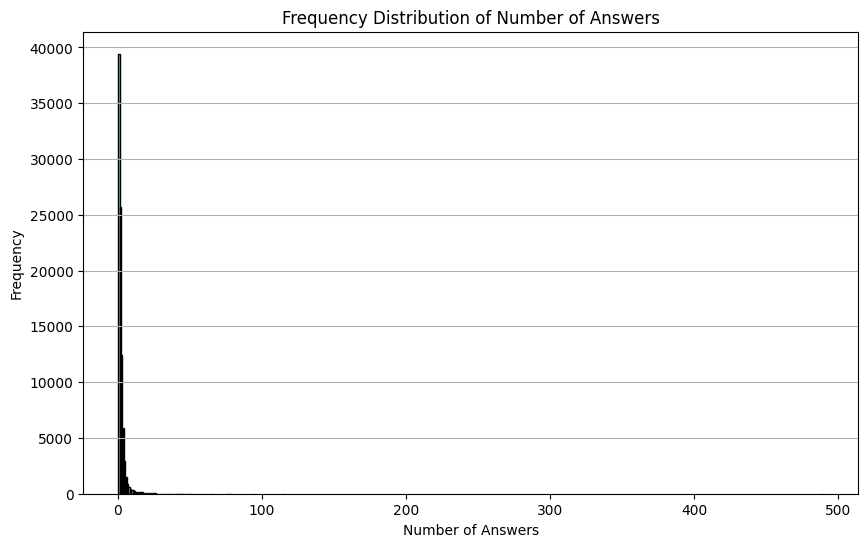

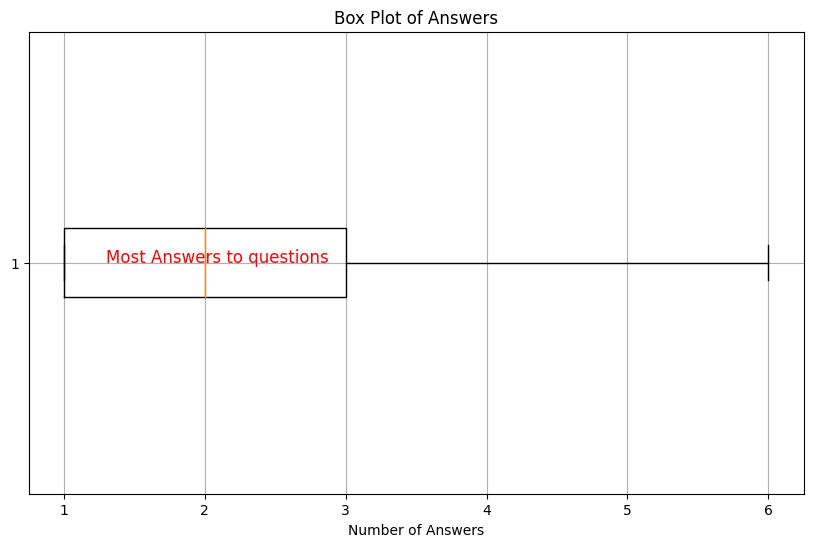

In [ ]:
no_of_questions = len(raw_train_dataset)
list_of_numbers_of_answers = [len(raw_train_dataset[qeustion]['answers']['a_id']) for qeustion in range(len(raw_train_dataset))]
average_asnwers_per_question = np.average(list_of_numbers_of_answers)
print('list_of_numbers_of_answers: ', list_of_numbers_of_answers[:10])
print('average_asnwers_per_question: ',average_asnwers_per_question)

no_answers,frequency = np.unique(list_of_numbers_of_answers, return_counts=True)




plt.figure(figsize=(10, 6))
plt.bar(no_answers, frequency, color='skyblue', edgecolor='black')
plt.title('Frequency Distribution of Number of Answers')
plt.xlabel('Number of Answers')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

expanded_scores = []
for s, f in zip(no_answers, frequency):
    expanded_scores.extend([s] * f)


plt.figure(figsize=(10, 6))
plt.boxplot(expanded_scores, vert=False, showfliers=False)
plt.title('Box Plot of Answers')
plt.xlabel('Number of Answers')
plt.text(1.3, 1, 'Most Answers to questions', fontsize=12, color='red')
plt.grid(True)
plt.show()

##Let's find asnwers word frequency, considering categories

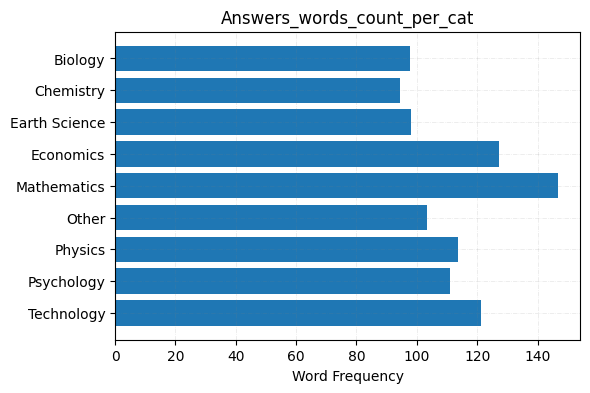

Average word count for answers of category "Biology": 97
Average word count for answers of category "Chemistry": 94
Average word count for answers of category "Earth Science": 97
Average word count for answers of category "Economics": 127
Average word count for answers of category "Mathematics": 146
Average word count for answers of category "Other": 103
Average word count for answers of category "Physics": 113
Average word count for answers of category "Psychology": 110
Average word count for answers of category "Technology": 121


In [ ]:
answers_words_count_per_cat = {}
answers_words_count = []

for cat in np.unique(dataset_dict['category']):
  answers_words_count = []
  for item in dataset['train']:
    if item['category'] == cat:
      for ans in item['answers']['text']:
        answers_words_count.append(len(ans.split()))
  answers_words_count_per_cat[cat] = answers_words_count


categories_names = np.unique(dataset_dict['category'])
bars = [np.mean(answers_words_count_per_cat[cat]) for cat in answers_words_count_per_cat.keys()]

fig, ax = plt.subplots(figsize =(6, 4))
ax.barh(categories_names, bars)
# Show top values
ax.invert_yaxis()
# Add Plot Title
ax.set_title('Answers_words_count_per_cat',
             loc ='center', )

ax.grid( color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
ax.set_xlabel('Word Frequency')

plt.show()


for cat in answers_words_count_per_cat.keys():
  print(f'Average word count for answers of category "{cat}": {int(np.mean(answers_words_count_per_cat[cat]))}')

## Lower case


In [ ]:
#I tried to have lower case sentences, instead of sentences having captial words
capitilized_questions = dataset_dict['questions']
lowercase_questions = [question.lower() for question in capitilized_questions] # make all questions small
print('Lets see first lower case question VS first capitilzed question: Pay attention to <why> vs <Why? words')
print('*'*100)
print('lowercase_question 1--> ',lowercase_questions[0])
print('capitilized_question 1--> ', capitilized_questions[0])
print('')

# The same for answers
capitilized_answers = dataset_dict['answers']
lowercase_answers = []
for answers_list in capitilized_answers:
  lowercase_answers_list =[]
  for answer in answers_list:
      lowercase_answers_list.append(answer.lower())
  lowercase_answers.append(lowercase_answers_list)

print('Lets see first lower case answer VS first capitilzed answer of frist question:')
print('*'*100)
print('lowercase_question 1--> ',lowercase_answers[0][0])
print('capitilized_question 1--> ', capitilized_answers[0][0])
print('\n')
print('*'*100)
print('From now on, we can use lowercase inputs to our model')
print('*'*100)


Lets see first lower case question VS first capitilzed question: Pay attention to <why> vs <Why? words
****************************************************************************************************
lowercase_question 1-->  why there was a 'leap second' added to the end of 2016?
capitilized_question 1-->  Why there was a 'leap second' added to the end of 2016?

Lets see first lower case answer VS first capitilzed answer of frist question:
****************************************************************************************************
lowercase_question 1-->  the rotation of the earth is not a constant. in fact the rotation of the earth is slowing down, which means that a full day is getting slightly longer. without leap seconds our clocks would slowly drift ever so slightly out of sync with the actual day. we could deal with this by redefining how how long 1 second is, making it slightly longer so that one day is still exactly 24*60*60 seconds. but in practice that is really i

## Unique words

In [ ]:
# In the following code, we can see unique vocabs of each question

question_list_words = [lowercase_question.split() for lowercase_question in lowercase_questions] # Find list of words of each questions and store them in a list
question_list_vocabs = [sorted(set(words)) for words in question_list_words]  # Find unqiqe vocabularies of the each list of words


# Just to show unique vocabularies

print('In the following questions, try to keep q_3 in mind,in particular, its "(like" word:\n')
iteration = 0
for index, vocabs  in enumerate(question_list_vocabs):
  print(f'Q_{index+1} has these unique vocabs:')
  print(vocabs)
  print('*'*100)
  iteration+=1
  if iteration ==5:
    break


In the following questions, try to keep q_3 in mind,in particular, its "(like" word:

Q_1 has these unique vocabs:
["'leap", '2016?', 'a', 'added', 'end', 'of', "second'", 'the', 'there', 'to', 'was', 'why']
****************************************************************************************************
Q_2 has these unique vocabs:
['claim', 'do', 'how', 'land?', 'undiscovered', 'you']
****************************************************************************************************
Q_3 has these unique vocabs:
['(like', 'beings', 'cgi', 'do', 'fail', 'great', 'human', 'in', 'it', 'non-human', 'on', 'one)', 'realistic', 'rouge', 'so', 'sw', 'to', 'warcraft)?', 'we', 'why', 'yet']
****************************************************************************************************
Q_4 has these unique vocabs:
['a', 'and', 'breath,', 'calm', 'deep', 'down', 'exhale?', 'few', 'for', 'hold', 'is', 'it', 'seconds', 'take', 'that', 'we', 'when', 'why']
**********************************

In [ ]:
# In the following code, we can see unique vocabs of each answer
answer_list_vocabs = []

for lowercase_answer_list in lowercase_answers:
  answer_list_vocabs_small = []

  for lowercase_answer in lowercase_answer_list:
      words = lowercase_answer.split()
      vocabs = sorted(set(words))
      answer_list_vocabs_small.append(vocabs)

  answer_list_vocabs.append(answer_list_vocabs_small)


# Just to show unique vocabularies

iteration = 0
for index, vocabs_list  in enumerate(answer_list_vocabs):
  for index1, vocabs in enumerate(vocabs_list):
     print(f'A_{index1+1} of Q_{index+1} has these unique vocabs:')
     print(vocabs)
     print('--'*10)
  print('\n')
  print('*'*100)
  iteration+=1
  if iteration ==2:
    break


A_1 of Q_1 has these unique vocabs:
['1', '24*60*60', 'a', 'actual', 'ahead', 'but', 'by', 'clocks', 'constant.', 'could', 'couple', 'day', 'day.', 'deal', 'down,', 'drift', 'earth', 'easier', 'ever', 'every', 'exactly', 'fact', 'for', 'full', 'getting', 'how', 'in', 'inconvenient', 'is', 'is,', 'it', 'its', 'just', 'leap', 'long', 'longer', 'longer.', 'lot', 'making', 'means', 'move', 'not', 'of', 'on', 'one', 'or', 'our', 'out', 'practice', 'precise', 'really', 'redefining', 'relies', 'rotation', 'second', 'seconds', 'seconds.', 'slightly', 'slowing', 'slowly', 'so', 'so.', 'still', 'sync', 'technology', 'that', 'the', 'this', 'timing.', 'to', 'us', 'very', 'we', 'which', 'with', 'without', 'would', 'years']
--------------------
A_2 of Q_1 has these unique vocabs:
['24', '7am', '7pm', 'a', 'about', 'actually', 'add', 'all', 'also', 'always', 'an', 'and', 'around', 'at', 'away', 'be', 'being', 'biggest', 'bit,', 'bug.', 'but', 'can', 'cause', 'caused', 'changed,', 'check', 'code', 'co

## Remove punctuations

In [ ]:
import string, re
regex = '[' + string.punctuation + ']'
print(f'These {regex} punctuations should be deleted')

These [!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~] punctuations should be deleted


In [ ]:
# remove punctuations
lowercase_questions_nopunctuation = [re.sub(regex,'',lowercase_question)for lowercase_question in lowercase_questions ]

question_list_vocabs_nonpunctuation = [lowercase_question_nonpunctuation.split() for lowercase_question_nonpunctuation in lowercase_questions_nopunctuation]
question_list_vocabs_nonpunctuation = [sorted(set(words)) for words in question_list_vocabs_nonpunctuation]

# Again find unique vocabs

print('See first 5 questions without punctuations:')
iteration = 0
for index, vocabs  in enumerate(question_list_vocabs_nonpunctuation):
  print(f'Q_{index+1} has these unique vocabs:')
  print(vocabs)
  print('*'*100)
  iteration+=1
  if iteration ==5:
    break

print('*'*100)
print('*'*100)
print('*'*100)
print('See the difference between questions with punctuations and not punctuations:')
print('Qustion 3 with punctuations is:')
print(question_list_vocabs[2])
print('Qustion 3 witout punctuations is:')
print(question_list_vocabs_nonpunctuation[2])


See first 5 questions without punctuations:
Q_1 has these unique vocabs:
['2016', 'a', 'added', 'end', 'leap', 'of', 'second', 'the', 'there', 'to', 'was', 'why']
****************************************************************************************************
Q_2 has these unique vocabs:
['claim', 'do', 'how', 'land', 'undiscovered', 'you']
****************************************************************************************************
Q_3 has these unique vocabs:
['beings', 'cgi', 'do', 'fail', 'great', 'human', 'in', 'it', 'like', 'nonhuman', 'on', 'one', 'realistic', 'rouge', 'so', 'sw', 'to', 'warcraft', 'we', 'why', 'yet']
****************************************************************************************************
Q_4 has these unique vocabs:
['a', 'and', 'breath', 'calm', 'deep', 'down', 'exhale', 'few', 'for', 'hold', 'is', 'it', 'seconds', 'take', 'that', 'we', 'when', 'why']
***************************************************************************************

In [ ]:
# The same for answers
# remove punctuations

lowercase_answers_nopunctuation = []
for lowercase_answer_list  in lowercase_answers:
  lowercase_answers_nopunctuation_small = []
  for lowercase_answer in lowercase_answer_list:
    lowercase_answers_nopunctuation_small.append(re.sub(regex,'',lowercase_answer))

  lowercase_answers_nopunctuation.append(lowercase_answers_nopunctuation_small)


# Find unique words again
answer_list_vocabs_nonpunctuation = []
for lowercase_answer_list_nonpunctuation in lowercase_answers_nopunctuation:
  answer_list_vocabs_nonpunctuation_small =[]
  for lowercase_answer_nonpunctuation in lowercase_answer_list_nonpunctuation:
    words = lowercase_answer_nonpunctuation.split()
    vocabs = sorted(set(words))
    answer_list_vocabs_nonpunctuation_small.append(vocabs)

  answer_list_vocabs_nonpunctuation.append(answer_list_vocabs_nonpunctuation_small)


print('In the following part, you can see unique words of each answer after removing punctuations from sentences:\n')
iteration = 0
for index, vocabs_list  in enumerate(answer_list_vocabs_nonpunctuation):
  for index1, vocabs in enumerate(vocabs_list):
     print(f'A_{index1+1} of Q_{index+1} has these unique vocabs:')
     print(vocabs)
     print('--'*10)
  print('\n')
  print('*'*100)
  iteration+=1
  if iteration ==2:
    break

In the following part, you can see unique words of each answer after removing punctuations from sentences:

A_1 of Q_1 has these unique vocabs:
['1', '246060', 'a', 'actual', 'ahead', 'but', 'by', 'clocks', 'constant', 'could', 'couple', 'day', 'deal', 'down', 'drift', 'earth', 'easier', 'ever', 'every', 'exactly', 'fact', 'for', 'full', 'getting', 'how', 'in', 'inconvenient', 'is', 'it', 'its', 'just', 'leap', 'long', 'longer', 'lot', 'making', 'means', 'move', 'not', 'of', 'on', 'one', 'or', 'our', 'out', 'practice', 'precise', 'really', 'redefining', 'relies', 'rotation', 'second', 'seconds', 'slightly', 'slowing', 'slowly', 'so', 'still', 'sync', 'technology', 'that', 'the', 'this', 'timing', 'to', 'us', 'very', 'we', 'which', 'with', 'without', 'would', 'years']
--------------------
A_2 of Q_1 has these unique vocabs:
['24', '7am', '7pm', 'a', 'about', 'actually', 'add', 'all', 'also', 'always', 'an', 'and', 'around', 'at', 'away', 'be', 'being', 'biggest', 'bit', 'bug', 'but', 'c

## Stemming and Lemmatization

- Stemming reduces word-forms to stems in order to reduce size, whereas lemmatization reduces the word-forms to linguistically valid lemmas. For example, the stem of the word ‘happy’ is ‘happi’, but its lemma is ‘happy’, which is linguistically valid.

- Lemmatization is usually more sophisticated and requires some sort of lexica. Stemming, on the other hand, can be achieved with simple rule-based approaches.

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize


nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

stop_words = set(stopwords.words('english'))

# an instance of Word Net Lemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


### Part of Speech Tagging (POS Tagging)

As it is clear from the above code sections, for a correct lemmatization task, we need to detect the POS (part of speech) of each token of each question and answer.

Since for example word "leaves" could be transformed to eitehr "leaf" or "leave" based on its part of speech.

In [ ]:
# Define a function to map NLTK to WordNet POS tags
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return 'a'  # adjective
    elif treebank_tag.startswith('V'):
        return 'v'  # verb
    elif treebank_tag.startswith('N'):
        return 'n'  # noun
    elif treebank_tag.startswith('R'):
        return 'r'  # adverb
    else:
        return 'n'  # default to noun if not found

Lemmatize questions:

In [ ]:
# Lemmatize each token based on POS-tag
# We have to do this for all questions tokens
# So first we have to tokenize sentences

lemmatizer = WordNetLemmatizer()
lemmatized_questions_pos = []

for question in dataset_dict['questions']:
  # sent_tokenize is one of instances of PunktSentenceTokenizer from the nltk.tokenize.punkt module
  wordsList = nltk.word_tokenize(question)

  # removing stop words from wordList
  # wordsList = [w for w in wordsList if not w in stop_words]

  #  Using a Tagger. Which is part-of-speech tagger or POS-tagger.
  tagged = nltk.pos_tag(wordsList)

  # Lemmatize using the mapped POS tags
  lemmatized_words_pos = [lemmatizer.lemmatize(word, pos=get_wordnet_pos(tag)) for word, tag in tagged]
  lemmatized_questions_pos.append(lemmatized_words_pos)


In [ ]:
print(len(lemmatized_questions_pos))
print(len(dataset_dict['questions']))

91772
91772


Lemmatize answers:

In [ ]:
# Lemmatize each token based on POS-tag
# We have to do this for all answers tokens
# So first we have to tokenize sentences

lemmatizer = WordNetLemmatizer()
lemmatized_answers_pos = []

for ans_list in dataset_dict['answers']:
  lemmatized_ans_list_pos = []
  for ans in ans_list:

    # sent_tokenize is one of instances of PunktSentenceTokenizer from the nltk.tokenize.punkt module
    wordsList = nltk.word_tokenize(question)

    # removing stop words from wordList
    # wordsList = [w for w in wordsList if not w in stop_words]

    #  Using a Tagger. Which is part-of-speech tagger or POS-tagger.
    tagged = nltk.pos_tag(wordsList)

    # Lemmatize using the mapped POS tags
    lemmatized_words_pos = [lemmatizer.lemmatize(word, pos=get_wordnet_pos(tag)) for word, tag in tagged]
    lemmatized_ans_list_pos.append(lemmatized_words_pos)

  lemmatized_answers_pos.append(lemmatized_ans_list_pos)

In [ ]:
print(len(dataset_dict['answers']))

print(len(lemmatized_answers_pos))

91772
91772


Now lets check how this lemmatizer treats emoticons or other languages in the dataset.

It wont change neither the emoticons nor other languages written like Chinese or Korean, So that's OK!

In [ ]:
for i , s in enumerate(dataset_dict['questions']):
  if s.find('Korean') != -1:
    print(i, s)

29 How to type Korean?
1991 How is being dyslexic in symbol languages (Chinese, Japanese, Korean) different from being dyslexic in English?
4732 Why does US restrain from shooting down N.Korean missiles?
14442 Why do Japanese and Korean manufacturers seem to make such a wide variety of products from a given company?
16330 Why are white people called "white people" when many Asians (mainly Korean, Japanese and Chinese) have pretty much the same skin color?
20762 Why do we focus more on the Vietnam war and less on the Korean war?
25494 Why can foreign car companies like Honda (Japanese), Volkswagen (German), and Hyundai (South Korean) make successful sedan-type cars in the United States, but domestic companies GM and Ford struggle to make good-selling sedans.
28889 Why are there so many movies made about the Vietnam war but so few about the Korean War?
29568 Steel is a very heavy product to ship, so how are the Chinese & Korean steel manufactures able to sell steel cheaper in the USA tha

In [ ]:
dataset_dict['answers'][29]

['Korean uses an alphabet called hangul. Individual letters are composed into syllables, with each syllable occupying one block. This means that the computer needs to know when you have finished typing one syllable and want to start typing the next: fortunately, the Korean writing system has very strict and simple rules that are quite easy to program into a computer. A syllable must start with a consonant, and must contain at least one vowel; it can then have another consonant at the end. The consonant letter "ㅇ" is "ng" at the end of a syllable, but silent at the beginning of a syllable, so this lets you write syllables beginning with a vowel *sound* without breaking the rule that in written Korean, all syllables must begin with a consonant. In your example, "saranghae" is "사랑해", the three blocks representing the syllables "sa-rang-hae". First, you type an "s", which in Korean is "ㅅ". Next comes a vowel, "ㅏ"; when you type that, the "ㅅ" changes to "사", the syllable "sa". That\'s fine,

In [ ]:
selftext = dataset_dict['selftext'][34]
wordsList1 = []
tagged1 = []

# Word tokenizers is used to find the words and punctuation in a string
wordsList1 = nltk.word_tokenize(selftext)

# removing stop words from wordList
# wordsList = [w for w in wordsList if not w in stop_words]

#  Using a Tagger. Which is part-of-speech tagger or POS-tagger.
tagged1 = nltk.pos_tag(wordsList1)

# Lemmatize using the mapped POS tags
lemmatized_words_pos = [lemmatizer.lemmatize(word, pos=get_wordnet_pos(tag)) for word, tag in tagged1]

print(selftext)
print("~~~~~~~~~~~~~~")
print(lemmatized_words_pos)

I know it seems irrational, but Felix Baumgartner! Thanks 😊 EDIT: Thanks everyone for all your replies :). Loving reading them! Just like to add, I know this can't happen without special clothing etc., like what Baumgartner wore, or being in a pressurised compartment such as a cockpit. I'm just wondering, theoretically ;). Thanks again :).
~~~~~~~~~~~~~~
['I', 'know', 'it', 'seem', 'irrational', ',', 'but', 'Felix', 'Baumgartner', '!', 'Thanks', '😊', 'EDIT', ':', 'Thanks', 'everyone', 'for', 'all', 'your', 'reply', ':', ')', '.', 'Loving', 'read', 'them', '!', 'Just', 'like', 'to', 'add', ',', 'I', 'know', 'this', 'ca', "n't", 'happen', 'without', 'special', 'clothing', 'etc.', ',', 'like', 'what', 'Baumgartner', 'wear', ',', 'or', 'be', 'in', 'a', 'pressurised', 'compartment', 'such', 'a', 'a', 'cockpit', '.', 'I', "'m", 'just', 'wondering', ',', 'theoretically', ';', ')', '.', 'Thanks', 'again', ':', ')', '.']


In [ ]:
selftext = dataset_dict['answers'][29][0]
wordsList1 = []
tagged1 = []

# Word tokenizers is used to find the words and punctuation in a string
wordsList1 = nltk.word_tokenize(selftext)

# removing stop words from wordList
# wordsList = [w for w in wordsList if not w in stop_words]

#  Using a Tagger. Which is part-of-speech tagger or POS-tagger.
tagged1 = nltk.pos_tag(wordsList1)

# Lemmatize using the mapped POS tags
lemmatized_words_pos = [lemmatizer.lemmatize(word, pos=get_wordnet_pos(tag)) for word, tag in tagged1]

print(selftext)
print("~~~~~~~~~~~~~~")
print(lemmatized_words_pos)

Korean uses an alphabet called hangul. Individual letters are composed into syllables, with each syllable occupying one block. This means that the computer needs to know when you have finished typing one syllable and want to start typing the next: fortunately, the Korean writing system has very strict and simple rules that are quite easy to program into a computer. A syllable must start with a consonant, and must contain at least one vowel; it can then have another consonant at the end. The consonant letter "ㅇ" is "ng" at the end of a syllable, but silent at the beginning of a syllable, so this lets you write syllables beginning with a vowel *sound* without breaking the rule that in written Korean, all syllables must begin with a consonant. In your example, "saranghae" is "사랑해", the three blocks representing the syllables "sa-rang-hae". First, you type an "s", which in Korean is "ㅅ". Next comes a vowel, "ㅏ"; when you type that, the "ㅅ" changes to "사", the syllable "sa". That's fine, bu

# Model "GPT"

First step is to install the openai library

In [ ]:
pip install --upgrade openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.7 MB/s eta 0:00:00


In [ ]:
openai_API_KEY = "SECRET KEY"

In [ ]:
def convert_to_gpt35_format(dataset):

  fine_tuning_data = []
  for i in range(len(dataset['questions'])):

      json_response = '{"best answer": "' + dataset['answers'][i][0] + '"}'
      fine_tuning_data.append({
          "messages": [
              {"role": "user", "content": dataset['questions'][i]},
              {"role": "system", "content": json_response}
          ]
      })
  return fine_tuning_data

In [ ]:
converted_data = convert_to_gpt35_format(dataset_dict)

In [ ]:
print(len(converted_data))

converted_data[:2]

91772


[{'messages': [{'role': 'user',
    'content': "Why there was a 'leap second' added to the end of 2016?"},
   {'role': 'system',
    'content': '{"best answer": "the rotation of the earth is not a constant. in fact the rotation of the earth is slowing down, which means that a full day is getting slightly longer. without leap seconds our clocks would slowly drift ever so slightly out of sync with the actual day. we could deal with this by redefining how how long 1 second is, making it slightly longer so that one day is still exactly 24*60*60 seconds. but in practice that is really inconvenient for a lot of our technology which relies on very precise timing. its easier to just move us ahead one second every couple of years or so."}'}]},
 {'messages': [{'role': 'user',
    'content': 'How do you claim undiscovered land?'},
   {'role': 'system',
    'content': '{"best answer": "Imagine you are out walking in the woods near your house and you find a cave. You think to yourself, "Gee that\'s

Make sure the dataset is in correct json format

In [ ]:
import json
json.loads(converted_data[0]['messages'][-1]['content'])

{'best answer': 'the rotation of the earth is not a constant. in fact the rotation of the earth is slowing down, which means that a full day is getting slightly longer. without leap seconds our clocks would slowly drift ever so slightly out of sync with the actual day. we could deal with this by redefining how how long 1 second is, making it slightly longer so that one day is still exactly 24*60*60 seconds. but in practice that is really inconvenient for a lot of our technology which relies on very precise timing. its easier to just move us ahead one second every couple of years or so.'}

In [ ]:
from sklearn.model_selection import train_test_split

# Stratified splitting. Assuming 'Top Category' can be used for stratification
train_data, val_data = train_test_split(
    converted_data,
    test_size=0.2,
    # stratify=dataset['Top Category'],
    random_state=42  # for reproducibility
)

In [ ]:
def write_to_jsonl(data, file_path):
    with open(file_path, 'w') as file:
        for entry in data:
            json.dump(entry, file)
            file.write('\n')

training_file_name = "train.jsonl"
validation_file_name = "val.jsonl"

write_to_jsonl(train_data, training_file_name)
write_to_jsonl(val_data, validation_file_name)

In [ ]:
from openai import OpenAI
client = OpenAI(api_key=openai_API_KEY)

# Upload Training and Validation Files
training_file = client.files.create(
    file=open(training_file_name, "rb"), purpose="fine-tune"
)
validation_file = client.files.create(
    file=open(validation_file_name, "rb"), purpose="fine-tune"
)

# Create Fine-Tuning Job
suffix_name = "yt_tutorial"
response = client.fine_tuning.jobs.create(
    training_file=training_file.id,
    validation_file=validation_file.id,
    model="gpt-3.5-turbo",
    suffix=suffix_name,
)

BadRequestError: Error code: 400 - {'error': {'message': 'Fine-tuning jobs cannot be created on an Explore plan. You can upgrade to a paid plan on your billing page: https://platform.openai.com/account/billing/overview', 'type': 'invalid_request_error', 'param': None, 'code': 'exceeded_quota'}}

Testing fine-tuned model

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def format_test(row):
    formatted_message = [{"role": "user", "content": row['Support Query']}]
    return formatted_message

def predict(test_messages, fine_tuned_model_id):
    response = client.chat.completions.create(
        model=fine_tuned_model_id, messages=test_messages, temperature=0, max_tokens=50
    )
    return response.choices[0].message.content

def store_predictions(test_df, fine_tuned_model_id):
    test_df['Prediction'] = None
    for index, row in test_df.iterrows():
        test_message = format_test(row)
        prediction_result = predict(test_message, fine_tuned_model_id)
        test_df.at[index, 'Prediction'] = prediction_result

    test_df.to_csv("predictions.csv")


# Model T5

In [9]:
def clear_dataset_4_finetuning(dataset_dict):
  df = []
  for i, ans_list in enumerate(dataset_dict['answers']):
    for j, ans in enumerate(ans_list):
      df.append(
          {
              'question': dataset_dict['questions'][i],
              'answer': dataset_dict['answers'][i][j],
              'score': dataset_dict['score'][i][j],
              'selftext': dataset_dict['selftext'][i],
              'category':  dataset_dict['category'][i]
          }
      )
  df = pd.DataFrame(df)

  return df

In [10]:
df_train = clear_dataset_4_finetuning(dataset_dict)

In [11]:
df_train.head()

,question,answer,score,selftext,category
0,Why there was a 'leap second' added to the end...,the rotation of the earth is not a constant. i...,44,,Other
1,Why there was a 'leap second' added to the end...,The Earth's rotation is not regular. It varies...,5,,Other
2,Why there was a 'leap second' added to the end...,Because the Earth's rotation is slowing. If yo...,4,,Other
3,How do you claim undiscovered land?,Imagine you are out walking in the woods near ...,195,"If your on a boat, sailing through lets say th...",Other
4,How do you claim undiscovered land?,"By force. Historically, nations have defended ...",39,"If your on a boat, sailing through lets say th...",Other


In [12]:
from transformers import T5ForConditionalGeneration, T5Tokenizer, Trainer, TrainingArguments
from datasets import load_dataset, load_metric
import torch

In [13]:
# Split the datafame_train to train, validate, test

import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming df is your DataFrame
train_df, test_df = train_test_split(df_train, test_size=0.2, random_state=42)  # 20% for testing
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)  # 25% of 80% for validation

# Convert to Hugging Face datasets
from datasets import Dataset

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

In [14]:
model_name = 't5-small'

tokenizer = T5Tokenizer.from_pretrained(model_name)

def preprocess_data_tokenization(examples):
  inputs = ["explain: " + q for q in examples['question']]
  model_inputs = tokenizer(inputs, max_length=128, truncation=True, padding='max_length')

  # Our target will be the answers
  with tokenizer.as_target_tokenizer():
      labels = tokenizer(examples['answer'], max_length=128, truncation=True, padding='max_length')

  model_inputs['labels'] = labels['input_ids']
  return model_inputs

# encoded_dataset = df_train.apply(preprocess_data_tokenization, axis=1)

# Apply the preprocess function
train_dataset = train_dataset.map(preprocess_data_tokenization, batched=True)
val_dataset = val_dataset.map(preprocess_data_tokenization, batched=True)
test_dataset = test_dataset.map(preprocess_data_tokenization, batched=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/134453 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3921: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/44818 [00:00<?, ? examples/s]

Map:   0%|          | 0/44818 [00:00<?, ? examples/s]

In [15]:
model = T5ForConditionalGeneration.from_pretrained(model_name)

In [16]:
from transformers import T5ForConditionalGeneration, TrainingArguments, Trainer


In [17]:

training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01
)


In [23]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset.select(range(2000)),
    eval_dataset=val_dataset.select(range(1000)),
    tokenizer=tokenizer
)



In [24]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,3.172627
2,No log,3.070078
3,No log,3.054723


TrainOutput(global_step=375, training_loss=3.613568359375, metrics={'train_runtime': 126.7278, 'train_samples_per_second': 47.346, 'train_steps_per_second': 2.959, 'total_flos': 203012702208000.0, 'train_loss': 3.613568359375, 'epoch': 3.0})

In [25]:
results = trainer.evaluate(test_dataset.select(range(1000)))
print(results)

model.save_pretrained('./finetuned-t5-qa')
tokenizer.save_pretrained('./finetuned-t5-qa')


{'eval_loss': 3.0035135746002197, 'eval_runtime': 6.0981, 'eval_samples_per_second': 163.987, 'eval_steps_per_second': 10.331, 'epoch': 3.0}


('./finetuned-t5-qa/tokenizer_config.json',
 './finetuned-t5-qa/special_tokens_map.json',
 './finetuned-t5-qa/spiece.model',
 './finetuned-t5-qa/added_tokens.json')

In [26]:
# predict using the finetuned saved model

from transformers import T5ForConditionalGeneration, T5Tokenizer

model_path = './finetuned-t5-qa'  # adjust this path to where you've saved your model

# Load the trained model and tokenizer
saved_model = T5ForConditionalGeneration.from_pretrained(model_path)
saved_tokenizer = T5Tokenizer.from_pretrained(model_path)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [28]:
def generate_answer(question):
    input_text = "question: " + question  # format input as the model expects
    input_ids = saved_tokenizer.encode(input_text, return_tensors="pt")  # convert input to ids and create a tensor

    # Generate outputs
    output_ids = saved_model.generate(input_ids)

    # Decode the output IDs to a string
    answer = saved_tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return answer

In [29]:
question = "What is the capital of France?"
answer = generate_answer(question)
print("Answer:", answer)

Answer: France


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
